In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sb  
from scipy.io import loadmat  
%matplotlib inline

raw_data = loadmat('../data/machine-learning-ex6/ex6/ex6data1.mat')  
raw_data  

data = pd.DataFrame(raw_data['X'], columns=['X1', 'X2'])  
data['y'] = raw_data['y']

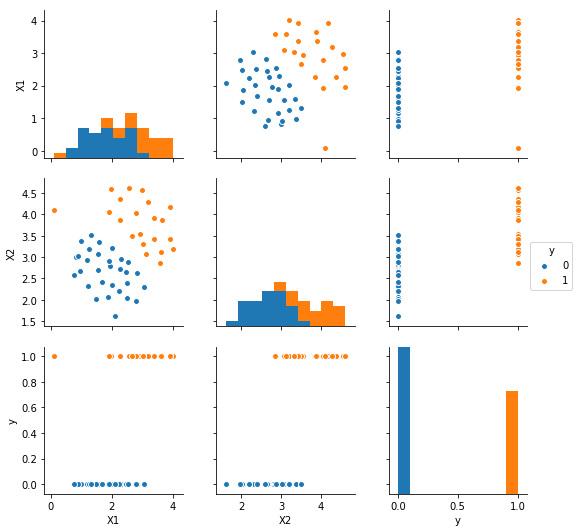

In [8]:

# Draw a categorical scatterplot to show each observation
sb.pairplot(data, hue="y")

There is a clear outlier in the 2D plots.

We're going to train a linear SVM to learn the class boundary. In this exercise we're not tasked with implementing an SVM from scratch, so we will use the one built into scikit-learn.

In [54]:
from sklearn import svm  
svc = svm.LinearSVC(C=1, loss='hinge', max_iter=1000)  
 

In this exercise we are suposed to change the value of C (which acts like a kind of regularisation constant), and see the effect on the results. Let's start with C=1

In [59]:
svc.fit(data[['X1', 'X2']], data['y'])  
svc.score(data[['X1', 'X2']], data['y'])  

0.9803921568627451

It appears that it mis-classified the outlier. Let's see what happens with a larger value of C.



In [49]:
svc2 = svm.LinearSVC(C=100, loss='hinge', max_iter=1000)  
svc2.fit(data[['X1', 'X2']], data['y'])  
svc2.score(data[['X1', 'X2']], data['y'])  

1.0

This time we got a perfect classification of the training data, however by increasing the value of C we've created a decision boundary that is no longer a natural fit for the data. We can visualize this by looking at the confidence level for each class prediction, which is a function of the point's distance from the hyperplane.

Text(0.5,1,'SVM (C=1) Decision Confidence')

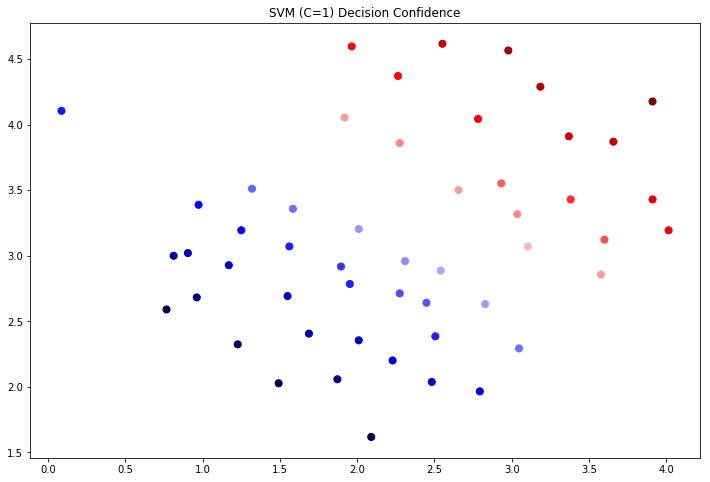

In [60]:
data['SVM 1 Confidence'] = svc.decision_function(data[['X1', 'X2']])

fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(data['X1'], data['X2'], s=50, c=data['SVM 1 Confidence'], cmap='seismic')  
ax.set_title('SVM (C=1) Decision Confidence')  

Text(0.5,1,'SVM (C=100) Decision Confidence')

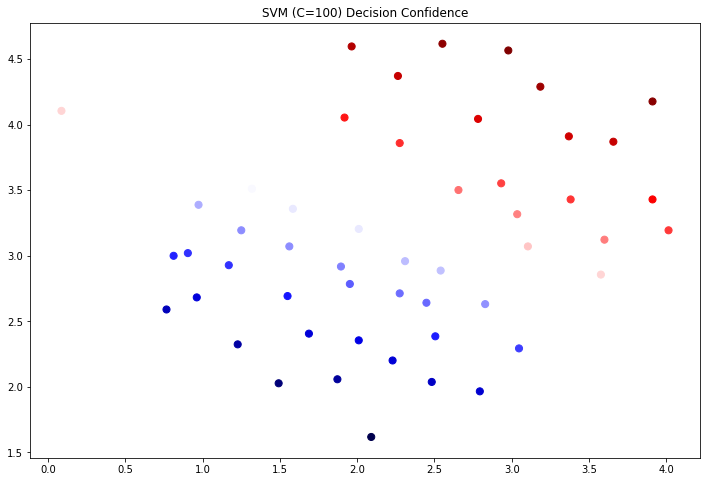

In [61]:
data['SVM 2 Confidence'] = svc2.decision_function(data[['X1', 'X2']])

fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(data['X1'], data['X2'], s=50, c=data['SVM 2 Confidence'], cmap='seismic')  
ax.set_title('SVM (C=100) Decision Confidence')  

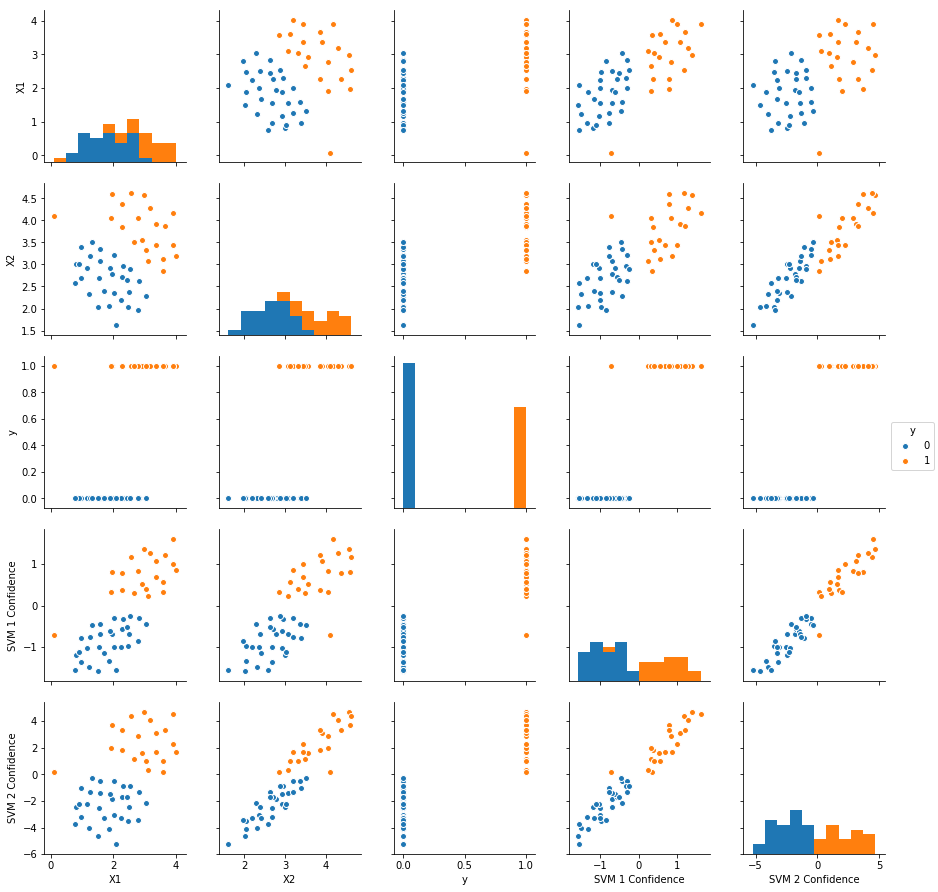

In [62]:
sb.pairplot(data, hue="y")

Now we're going to move from a linear SVM to one that's capable of non-linear classification using kernels. We're first tasked with implementing a gaussian kernel function. Although scikit-learn has a gaussian kernel built in, for transparency we'll implement one from scratch.

You can think of the Gaussian kernel as a similarity function that measures the “distance” between a pair of examples, (x(i),x(j)). The Gaussian kernel is also parameterized by a bandwidth parameter, σ, which determines how fast the similarity metric decreases (to 0) as the examples are further apart.

In [63]:
def gaussian_kernel(x1, x2, sigma):  
    return np.exp(-(np.sum((x1 - x2) ** 2) / (2 * (sigma ** 2))))

x1 = np.array([1.0, 2.0, 1.0])  
x2 = np.array([0.0, 4.0, -1.0])  
sigma = 2  
gaussian_kernel(x1, x2, sigma)  

0.32465246735834974

That result matches the expected value from the exercise. Next we're going to examine another data set, this time with a non-linear decision boundary.



In [65]:
raw_data = loadmat('../data/machine-learning-ex6/ex6/ex6data2.mat')  

data2 = pd.DataFrame(raw_data['X'], columns=['X1', 'X2'])  
data2['y'] = raw_data['y']


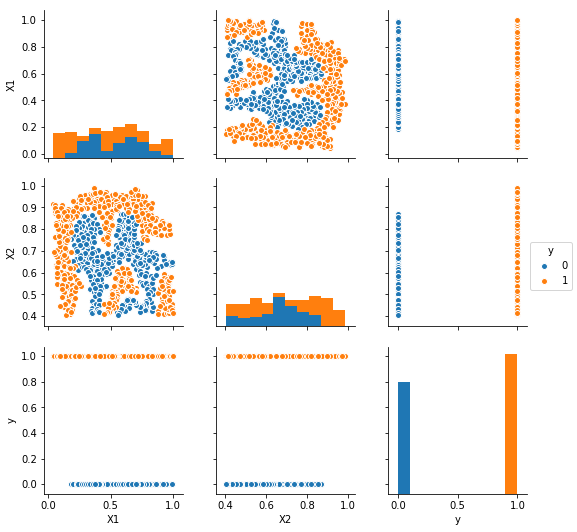

In [66]:
sb.pairplot(data2, hue="y")

We will use a scikit learn built in Gaussian Kernel algorithm and check the accuracy on the prediction.

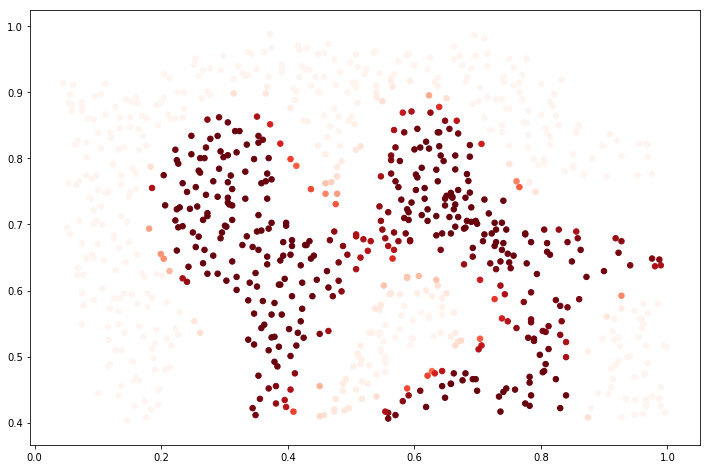

In [73]:
svc = svm.SVC(C=1000, gamma=10, probability=True)  
svc.fit(data2[['X1', 'X2']], data2['y'])  
data2['Probability'] = svc.predict_proba(data2[['X1', 'X2']])[:,0]

fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(data2['X1'], data2['X2'], s=30, c=data2['Probability'], cmap='Reds')  

This pairplot shows how the probability values behave for both species, it seems to be working well for most cases.

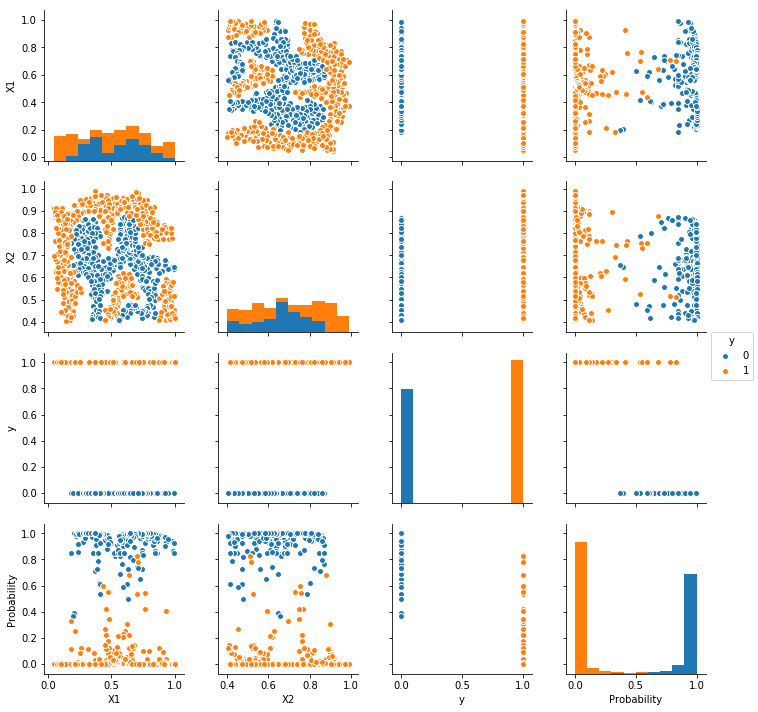

In [74]:
sb.pairplot(data2, hue="y")

For the third data set we're given both training and validation sets and tasked with finding optimal hyper-parameters for an SVM model based on validation set performance. We will use scikit-learn's built-in grid search to do this quite easily.



In [75]:
raw_data = loadmat('../data/machine-learning-ex6/ex6/ex6data3.mat')  

X = raw_data['X']  
Xval = raw_data['Xval']  
y = raw_data['y'].ravel()  
yval = raw_data['yval'].ravel()

In [76]:
data3 = pd.DataFrame(raw_data['X'], columns=['X', 'Xval'])  
data3['y'] = raw_data['y']

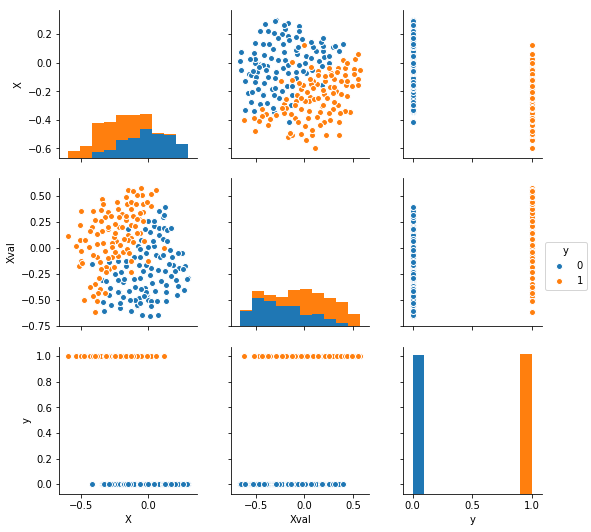

In [77]:
sb.pairplot(data3, hue="y")

In [135]:
from sklearn import svm, grid_search
def svc_param_selection(X, y,Xval, yval):
    Cs = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]  
    gammas = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_s = grid_search.GridSearchCV(svm.SVC(), param_grid)
    grid_s.fit(X, y)
    grid_s.best_params_
    score = grid_s.score(Xval, yval)
    return grid_s.best_params_, score

But this grid search is optimising on the training dataset. To optimise on the validation set:

In [136]:
C_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]  
gamma_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]

best_score = 0  
best_params = {'C': None, 'gamma': None}

for C in C_values:  
    for gamma in gamma_values:
        svc = svm.SVC(C=C, gamma=gamma)
        svc.fit(X, y)
        score = svc.score(Xval, yval)

        if score > best_score:
            best_score = score
            best_params['C'] = C
            best_params['gamma'] = gamma

best_score, best_params  

(0.965, {'C': 0.3, 'gamma': 100})

## Spam clasification

In this part our objective is to use SVMs to build a spam filter. In the exercise text, there's a task involving some text pre-processing to get our data in a format suitable for an SVM to handle. Rather than reproduce these pre-processing steps, we are going to skip ahead to the machine learning task which involves building a classifier from pre-processed train and test data sets consisting of spam and non-spam emails transformed to word occurance vectors.

In [138]:
spam_train = loadmat('../data/machine-learning-ex6/ex6/spamTrain.mat')  
spam_test = loadmat('../data/machine-learning-ex6/ex6/spamTest.mat')

spam_train  

{'X': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 '__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Nov 13 14:27:25 2011',
 '__version__': '1.0',
 'y': array([[1],
        [1],
        [0],
        ...,
        [1],
        [0],
        [0]], dtype=uint8)}

In [139]:
X = spam_train['X']  
Xtest = spam_test['Xtest']  
y = spam_train['y'].ravel()  
ytest = spam_test['ytest'].ravel()

X.shape, y.shape, Xtest.shape, ytest.shape  

((4000, 1899), (4000,), (1000, 1899), (1000,))

Each document has been converted to a vector with 1,899 dimensions corresponding to the 1,899 words in the vocabulary. The values are binary, indicating the presence or absence of the word in the document. At this point, training and evaluation are just a matter of fitting the testing the classifer.



In [141]:
svc = svm.SVC(probability=True)  
svc.fit(X, y)  
print('Test accuracy = {0}%'.format(np.round(svc.score(Xtest, ytest) * 100, 2)))  

Test accuracy = 95.3%
